### System

The total Hamiltonian of the system is given by:

$
H = H_0 + H_{\text{SB}} = H_{\text{S}} + H_{\text{B}} + H_{\text{SB}}
$

where:
- $ H_{\text{S}} $ is the system Hamiltonian
- $ H_{\text{B}} $ is the bath Hamiltonian
- $ H_{\text{SB}} $ is the system-bath interaction Hamiltonian

#### System Hamiltonian

The system Hamiltonian $ H_{\text{S}} $ is modeled as a two level system:

$
H_{\text{S}} = \hbar \omega_at |e\rangle\langle e|
$

is defined by a two level system with ground state $ |g\rangle $, seperated from an excited state $ |e\rangle $ by $ \omega_at $.
The atom is polarized in the z direction


### The Coupling to the Environment is modeled with 
#### The Redfield Equation

... derivation from paper / Danis darivation...


The system-bath coupling is written in a general form as:

$
H_{SB} =  \sum_i S_i \otimes B_i,
$

where the coupling operators $ S_i $  are modeled as $ \sigma_z $ for dephasing and $ \sigma_x $ for relaxation.
and the different baths are uncorrelated. The correlation functions thus can be written as: 

$
C_{ij}(t) \equiv \langle B_i(t) B_j \rangle_B \equiv \delta_{ij} \langle B_i(t) B_j \equiv C_i(t)
$

Each System operator couples to its own bath.

**The SB interaction is treated within a linear response theory**: The monomers are linearly coupled to the bath oscillators and the coupling function $ F_i $ is specified as:

$
B_i = \sum_x g_x^i q_x^i =\sum_x g_x^i (a_x^{\dagger} + a_x) 
$

where the coupling parameter $ g_x^i $ describe the interaction of the system operator with mode $ x $ of the $ i-th $ bath.

For a bath of harmonic oscillators, analytic expressions for the bath correlation function (CF) and its Fourier transform can be obtained:

$
C_i(t) = \frac{1}{2} \sum_x (g_x^{(i)})^2 \left[ n(\omega_x) e^{i\omega_x t} + (1 + n(\omega_x)) e^{-i\omega_x t} \right],
$

where $ n(\omega) = 1 / (e^{\hbar\omega/k_B T} - 1) $ is the Bose-Einstein distribution function.

The spectral density function, $ J_i(\omega) $, which entirely describes the parameters of the bath, is defined for each monomer as:

$
J_i(\omega) = \frac{\pi}{2} \sum_x (g_x^{(i)})^2 \delta(\omega - \omega_x).
$

For convenience, we assume that the spectral density for both monomers is equivalent. For the calculations in this paper, the spectral density is taken to be of the form:

$
J(\omega) = g^2 \frac{\omega}{\omega_{\text{c}}} e^{-\omega/\omega_{\text{c}}},
$

where $ \omega_{\text{c}} $ is a cutoff frequency and $ g^2 $ is a dimensionless coupling strength parameter.


In [1]:
### IMPORTS ###
from bath_constants import (
    Boltzmann,
    hbar,
    ############## Bath parameters ##############
)
# functions from test_baths.py
from test_baths import (
    spectral_density_func_ohmic,
    spectral_density_func_drude_lorentz,
)
import matplotlib.pyplot as plt
from qutip import *
import numpy as np

# Import the outsourced plot settings
from plot_settings import *

In [2]:
# =============================
# PLOT BATH MODEL OVER FREQUENCIES AND TIMES
# =============================
temperatures = [1e-10, 1e-2, 1e1, 1e2]
num_points   = 100
frequencies  = np.linspace(1 * cutoff, 1.2 * cutoff, num_points)  # Frequency range for the plot
times        = np.linspace(0, 10 / cutoff, num_points)   # Time range for the plot

plt.figure(figsize=(10, 8))

### Plot power spectrum
plt.subplot(2, 1, 1)
for Temp in temperatures:
    # Update the bath model for the current temperature
    env = BosonicEnvironment.from_spectral_density(
        lambda w: spectral_density_func_ohmic(w, {"eta": eta, "cutoff": cutoff, "s": 1.0}),
        wMax=10 * cutoff,
        T=Temp
    )
    plt.plot(
        frequencies / cutoff,
        [env.spectral_density(w) for w in frequencies],
        label=f"T = {Temp:.1e}",
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][temperatures.index(Temp) % 4],
        color=f'C{temperatures.index(Temp)}'
    )
plt.xlabel(r'Frequency $\omega / \omega_cav$')
plt.ylabel(r'Power Spectrum $S(\omega)$')
plt.title(r"Power Spectrum for Different Temperatures")
plt.legend()

### Plot correlation function
plt.subplot(2, 1, 2)
for Temp in temperatures:
    # Update the bath model for the current temperature
    env = BosonicEnvironment.from_spectral_density(
        lambda w: spectral_density_func_ohmic(w, {"eta": eta, "cutoff": cutoff, "s": 1.0}),
        wMax=10 * cutoff,
        T=Temp
    )
    plt.plot(
        times * cutoff,
        [env.correlation_function(t) for t in times],
        label=f"T = {Temp:.1e}",
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][temperatures.index(Temp) % 4],
        color=f'C{temperatures.index(Temp)}'
    )
plt.xlabel(r'Time $t \omega_cav$')
plt.ylabel(r'Correlation Function $C(t)$')
plt.title(r"Correlation Function for Different Temperatures")
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'cutoff' is not defined

In [15]:
# =============================
# SYSTEM PARAMETERS     (**changeable**) 
# =============================
global Bath, omega_at, mu_at, rabi_0, delta, w_th, N_cav, N_at, omega_cav, g_at_cav, RWA, gamma_0_cav, gamma_0_at, gamma_phi, omega_L_at, omega_L_cav

omega_at = 1 * 2 * np.pi  # energy separation of the atomic states
mu_at    = .1 * omega_at   # dipole moment of the transition
N_cav   = 0              # 0 = no cavity present or even = cavity with N_cav levels
N_at    = 2              # 0 lvls = atom is not present or 2 lvls = atom is present
Temp    = 1e-6            # Temperature of the baths
w_th    = Boltzmann * Temp / hbar

omega_cav  = 1.0 * omega_at if N_cav != 0 else 0  # cavity energy separation
RWA        = False # between atom and cavity
g_at_cav   = 0 * omega_at if N_cav != 0  else 0  # coupling strength between cavity and atom

g_at       = 1e-3 * omega_at if N_at != 0  else 0  # coupling strength between cavity and atom
omega_L_at = 0.999 * omega_at

g_cav    = 0 * omega_cav if N_cav != 0  else 0  # coupling strength between cavity and atom
omega_L_cav = 0.99 * omega_cav


### Coupling to the bath
gamma_phi, gamma_0_at, gamma_0_cav = 1, .01, 0.01 #eta , eta / 3  # (**changeable**):  Dephasing and Decay rates
cutoff = 1e1 * omega_at # Adjust the cutoff frequency of the bath model based on the atomic frequency

def create_bath_model(eta, cutoff, Temp):
    """
    Create a bath model using the given parameters.

    Parameters:
    eta (float): Coupling strength to the bath.
    cutoff (float): Cutoff frequency of the bath model.
    Temp (float): Temperature of the system.

    Returns:
    bath_model: Spectral density of the bath.
    """
    args_ohmic = {"eta": eta, "cutoff": cutoff, "s": 1.0} # define bath parameters
    bath_args  = args_ohmic

    env = BosonicEnvironment.from_spectral_density(
        lambda w: spectral_density_func_ohmic(w, bath_args),
        wMax=10 * cutoff,
        T=Temp
    )
    return env.spectral_density

# =============================
# DEFINE ATOMIC / CAVITY DECAY CHANNELS and observables to keep track of
# =============================
decay_ops_strg = ( # which decay channels are present
    "Relax_at" if N_at != 0 else "",  # Relaxation for the atom
#    "Relax_cav" if N_cav != 0 else "",  # Relaxation for the cavity
#    "Deph_at" if N_at != 0 else "",  # Dephasing for the atom
###    "Deph_cav" if N_cav != 0 else "",  # Dephasing for the cavity, usefull?
)

e_ops_strg = ( # which observables to keep track of
    # atomic observables
    "sx" if N_at != 0 else "",
    "sy" if N_at != 0 else "",
    "sz" if N_at != 0 else "",
    "n_at" if N_at != 0 else "",
    
    # cavity observables
    "n_cav" if N_cav != 0 else "",
    "a + a.dag()"if N_cav != 0 else "",
)


# =============================
# DEFINE ATOMIC / CAVITY STATES AND OPERATORS
# =============================
# atom
if N_at != 0:
    atom_g, atom_e = basis(N_at, 0), basis(N_at, 1)  # Ground, Excited states

    sm_op   = atom_g * atom_e.dag()
    dip_op  = mu_at * (sm_op + sm_op.dag())

    sx_op   = (sm_op + sm_op.dag())  # sigmaX operator
    sy_op   = -1j * (atom_e * atom_g.dag() - atom_g * atom_e.dag())  # sigmaY operator
    sz_op   = atom_e * atom_e.dag() - atom_g * atom_g.dag()  # sigmaZ operator
    n_at_op = ket2dm(atom_e)  # number operator for the atom
# Cavity
if N_cav != 0:
    a_op      = destroy(N_cav)  # cavity annihilation operator
    n_cav_op  = a_op.dag() * a_op  # number operator for the cavity

if N_at != 0 and N_cav != 0:
    # Combined operators
    A_op      = tensor(a_op, qeye(N_at)) if N_at != 0 else a_op
    SM_op     = tensor(qeye(N_cav), sm_op) if N_at != 0 else None
    SX_op     = tensor(qeye(N_cav), sx_op) if N_at != 0 else None
    SY_op     = tensor(qeye(N_cav), sy_op) if N_at != 0 else None
    SZ_op     = tensor(qeye(N_cav), sz_op) if N_at != 0 else None

    N_at_op   = tensor(qeye(N_cav), n_at_op) if N_at != 0 else None
    N_cav_op  = tensor(n_cav_op, qeye(N_at)) if N_at != 0 else n_cav_op

elif N_cav != 0 and N_at == 0:
    SM_op = SX_op = SY_op = SZ_op = N_at_op = None

    A_op = a_op
    N_cav_op = n_cav_op
elif N_at != 0 and N_cav == 0:
    N_cav_op = A_op = None
    
    SM_op = sm_op
    SX_op = sx_op
    SY_op = sy_op
    SZ_op = sz_op
    N_at_op = n_at_op

def Hamilton(omega_at, omega_cav, N_cav, N_at, g_at_cav, g_at, g_cav, RWA):
    H_at  = 0
    H_cav = 0
    H_int = 0

    if N_at != 0:
        H_at = hbar * omega_at * SM_op.dag() * SM_op         # atom energy separation

    if N_cav != 0:
        H_cav += hbar * omega_cav * A_op.dag() * A_op  # cavity energy separation
    if g_at_cav != 0 and N_cav != 0 and N_at != 0:
        Rabi_0_at_cav = (mu_at * g_at_cav) / hbar
        if RWA:
            H_int += hbar * Rabi_0_at_cav * (A_op + A_op.dag()) * (SM_op + SM_op.dag())  # interaction
        else:
            H_int += hbar * Rabi_0_at_cav * (A_op * SM_op.dag() + A_op.dag() * SM_op)  # interaction

    H0 = H_at + H_cav + H_int  # total Hamiltonian
    return H0


def plot_energy_levels(omega_at, omega_cav, N_cav, N_at, g_at_cav, RWA):
    """
    Plots the energy levels as a function of cavity frequency.

    Parameters:
    omega_at : float
        Atomic frequency.
    omega_cav : float
        Cavity frequency.
    g_at_cav : float
        Coupling strength between atom and cavity.
    N_cav : int
        Number of cavity levels.
    N_at : int
        Number of atomic levels.
    RWA : bool
        Rotating wave approximation flag.
    """
    # Generate a range of frequencies around omega_at
    frequencies = np.linspace(-0.1 * omega_at, 0.1 * omega_at, 101)

    # Calculate Hamiltonians for each frequency
    H_list = [Hamilton(omega_at, omega_cav, N_cav, N_at, g_at_cav, g_at, g_cav, RWA) for wc in frequencies]

    # Calculate eigenenergies for each Hamiltonian
    eigenenergies = [H.eigenenergies() for H in H_list]

    # Plot the energy levels
    plt.figure(figsize=(5, 3))
    for i, energies in enumerate(zip(*eigenenergies)):
        plt.plot(frequencies / omega_at, np.array(energies) / omega_at,
                 label=f"Level {i+1}",
                 linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],
                 color=f'C{i}')

    # Add labels and title
    plt.xlabel(r'Frequency $\omega_cav / \omega_at$')
    plt.ylabel(r'Energy $E / \omega_at$')
    plt.title(r"Energy Levels as a Function of $\omega_cav / \omega_at$")
    plt.legend()
    plt.tight_layout()
    plt.show()


def create_decay_ops_from_strg(strg):
    if N_at != 0:
        psi_ini_at = atom_e   # atom initially excited
        # psi_ini_at = (atom_e + atom_g).unit()   # initial state
    if N_cav != 0:
        #psi_ini_cav = basis(N_cav, 1) # initially one PHOTON present
        psi_ini_cav = (basis(N_cav, N_cav - 1) + basis(N_cav, N_cav - 2) + basis(N_cav, 0)).unit()
        
    a_ops_list = []
    c_ops_list = []
    gamma_brme = 0
    gamma_me = 0

    # unpack the string
    if "Deph_at" in strg:
        
        a_ops_list.append(
            [SZ_op, create_bath_model(gamma_phi, cutoff, Temp)]  # Dephasing operator
        )
        c_ops_list.append(
            np.sqrt(gamma_phi) * SZ_op  # Collapse operator for dephasing
        )

        gamma_brme = gamma_phi
        gamma_me = gamma_phi

    if "Relax_at" in strg:

        n_th = n_thermal(omega_at, w_th)
        def S_w(w):
            if w >= 0:
                return (n_th + 1) * gamma_0_at
            else:
                if w_th == 0:
                    return 0 
                return (n_th + 1) * gamma_0_at * np.exp(w / w_th)      

#        a_ops_list.append([
#            SM_op + SM_op.dag(), # hermitian Relaxation operator
#            lambda w: S_w(w)
#            ]
#        )
# TODO S_w(w) is not yet equal to the effect of  bath_model(w)
        a_ops_list.append([
            SM_op + SM_op.dag(), 
            create_bath_model(gamma_0_at, cutoff, Temp)]  # Relaxation operator
        )
        c_ops_list.append([
            SM_op.dag() * np.sqrt(gamma_0_at * n_th),  # Collapse operator for relaxation
            SM_op       * np.sqrt(gamma_0_at * (n_th + 1))  # Collapse operator for relaxation
            ]
        )
        gamma_brme = gamma_0_at
        gamma_me = gamma_0_at

# THIS ONE REPRESENT THE SPONTANEOUS COUPLING between the atom and the cavity!! 
    if "Relax_cav" in strg:
        n_th = n_thermal(omega_cav, w_th)
        def S_w(w):
            if w >= 0:
                return (n_th + 1) * gamma_0_cav
            else:
                if w_th == 0:
                    return 0 
                return (n_th + 1) * gamma_0_cav * np.exp(w / w_th)      
    
#        a_ops_list.append([
#            (A_op + A_op.dag()),
#            lambda w : S_w(w)
#            ]
#        )

        a_ops_list.append([
            (A_op + A_op.dag()),
            create_bath_model(gamma_0_cav, cutoff, Temp)
            ]
        )        
        c_ops_list.append([
            A_op       * np.sqrt(gamma_0_cav * (n_th + 1)),
            A_op.dag() * np.sqrt(gamma_0_cav * (n_th)),
            ]
        )

        gamma_brme = gamma_0_cav
        gamma_me = gamma_0_cav
        
    if "Relax_at" in strg and "Deph_at" in strg:
        gamma_brme = (gamma_0_at + gamma_phi) / 2
        gamma_me = (gamma_0_at + gamma_phi) / 2
    
    if N_at != 0 and N_cav != 0:
        psi_ini = tensor(psi_ini_cav, psi_ini_at) if N_cav != 0 else psi_ini_at
    elif N_at != 0 and N_cav == 0:
        psi_ini = psi_ini_at
    elif N_cav != 0 and N_at == 0:
        psi_ini = psi_ini_cav

    return a_ops_list, c_ops_list, gamma_brme, gamma_me, psi_ini


def create_e_ops_from_strg(strg):
    e_ops_list = []
    e_ops_labels = []
    if "sx" in strg:
        e_ops_list.append(
            SX_op
        )
        e_ops_labels.append(
            r"$ \langle s_x \rangle $ "
        )

    if "sy" in strg:
        e_ops_list.append(
            SY_op
        )
        e_ops_labels.append(
            r"$ \langle s_y \rangle $ "
        )

    if "sz" in strg:
        e_ops_list.append(
            SZ_op
        )
        e_ops_labels.append(
            r"$ \langle s_z \rangle $ "
        )

    if "n_at" in strg:
        e_ops_list.append(
            N_at_op
        )
        e_ops_labels.append(
            r"$ \langle n_{\text{at}} \rangle $ "
        )
    if "n_cav" in strg:
        e_ops_list.append(
            N_cav_op
        )
        e_ops_labels.append(
            r"$ \langle n_{\text{cav}} \rangle $ "
        )
    if "a + a.dag()" in strg:
        e_ops_list.append(
            A_op + A_op.dag()
        )
        e_ops_labels.append(
            r"$ \langle A+A^\dagger \rangle $ "
        )

    return e_ops_list, e_ops_labels

H0 = Hamilton(omega_at, omega_cav, N_cav, N_at, g_at_cav, g_at, g_cav, RWA)


H_total = [
    H0,
]


### Add classical laser interactions / drive
if g_at != 0:
    global Rabi_0_at
    delta_at = omega_at - omega_L_at
    Rabi_0_at = (mu_at * g_at) / hbar
    Rabi_at = np.sqrt(Rabi_0_at**2 + delta_at**2)

    def H_drive_coeff_at(t):
        return hbar * Rabi_0_at * np.cos(omega_L_at * t) # interaction with a classical field
    
    DIP_op = SM_op + SM_op.dag()  # This is σ_x
    H_total.append([- DIP_op, H_drive_coeff_at])

if g_cav != 0:
    def H_drive_coeff_cav(t):
        return - g_cav * np.cos(omega_L * t)          # interaction with a classical field

    delta_cav = omega_at - omega_L_cav
    mu_cav = 1
    Rabi_0_cav = (mu_cav * g_at) / hbar
    Rabi_cav = np.sqrt(Rabi_0_cav**2 + delta_cav**2)

    H_drive_op_cav = (A_op + A_op.dag())
    H_total.append([- H_drive_op_cav, H_drive_coeff_cav])
H_total

[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0.         0.        ]
  [0.         6.28318531]],
 [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
  Qobj data =
  [[-0. -1.]
   [-1. -0.]],
  <function __main__.H_drive_coeff_at(t)>]]

c:\Users\leopo\anaconda3\envs\Master\Lib\site-packages\qutip\utilities.py:53: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


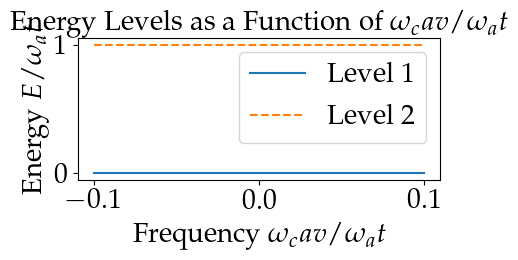

In [16]:
a_ops_list, c_ops_list, gamma_brme, gamma_me, psi_ini = create_decay_ops_from_strg(decay_ops_strg)

e_ops_list, e_ops_labels = create_e_ops_from_strg(e_ops_strg)

plot_energy_levels(omega_at, omega_cav, N_cav, N_at, g_at_cav, RWA)

[100.0, np.float64(846.7330159648682)]
 Total run time: 140.07s*] Elapsed 140.06s / Remaining 00:00:00:00***      12%           ] Elapsed 17.28s / Remaining 00:00:02:06
 Total run time:   6.70s*] Elapsed 6.70s / Remaining 00:00:00:00[*********41%           ] Elapsed 2.69s / Remaining 00:00:00:03[*********50%           ] Elapsed 3.28s / Remaining 00:00:00:03[*********50%           ] Elapsed 3.31s / Remaining 00:00:00:03[*********63%**         ] Elapsed 4.18s / Remaining 00:00:00:02[*********66%***        ] Elapsed 4.31s / Remaining 00:00:00:02[*********71%****       ] Elapsed 4.70s / Remaining 00:00:00:01[*********86%********   ] Elapsed 5.71s / Remaining 00:00:00:00[*********86%********   ] Elapsed 5.75s / Remaining 00:00:00:00[*********88%********   ] Elapsed 5.86s / Remaining 00:00:00:00[*********91%*********  ] Elapsed 6.03s / Remaining 00:00:00:00


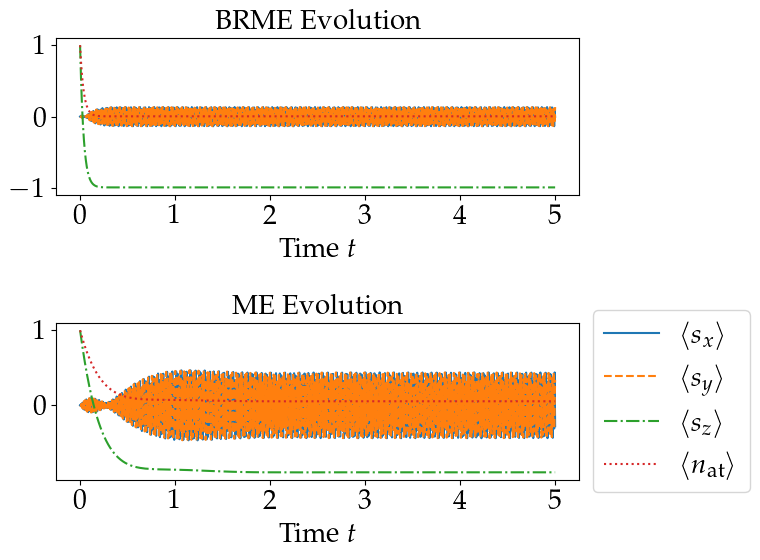

In [17]:
t_max = t_prd_at = t_prd_cav = t_half_at = t_half_cav = 0

### Determine characteristic times based on the setup
if g_at != 0:
    t_prd_at = 2 * np.pi / Rabi_at # Period of atomic Rabi oscillations
if g_cav != 0:
    t_prd_cav = 2 * np.pi / Rabi_cav # Period of cavity Rabi oscillations

if "Relax_at" in decay_ops_strg:
    t_half_at = 1 / gamma_0_at # Half-life of atomic relaxation
if "Relax_cav" in decay_ops_strg:
    t_half_cav = 1 / gamma_0_cav # Half-life of cavity relaxation

### Clear selection of t_max based on the setup
if g_at != 0            and g_cav == 0 and "Relax_at" not in decay_ops_strg and "Relax_cav" not in decay_ops_strg:
    t_max = t_prd_at
elif g_cav != 0         and g_at == 0 and "Relax_at" not in decay_ops_strg and "Relax_cav" not in decay_ops_strg:
    t_max = t_prd_cav
elif "Relax_at" in decay_ops_strg       and g_cav != 0 and g_at == 0 and "Relax_cav" not in decay_ops_strg:
    t_max = t_half_at
elif "Relax_cav" in decay_ops_strg      and g_cav != 0 and g_at == 0 and "Relax_at" not in decay_ops_strg:
    t_max = t_half_cav
else:
    non_zero_values = [val for val in [t_half_at, t_half_cav, t_prd_at, t_prd_cav] if val > 0]
    print(non_zero_values)
    t_max = sum(non_zero_values) / len(non_zero_values) if non_zero_values else 0

### Define time arrays for evolution
times_br = np.linspace(
    0,
    5 * t_max,
    1000
)  # High-resolution times array to do the evolutions
times_me = np.linspace(
    0,
    5 * t_max,
    1000
)  # High-resolution times array to do the evolutions

options = Options(
    store_states=True,
    progress_bar="enhanced",
#    atol=1e-6,
#    rtol=1e-4,
#    nsteps=10000  # default is 5000; increasing can help with tough integrations
)

### compute the evolution
result_brme = brmesolve(
    H_total,
    psi_ini,
    times_br,
    e_ops=e_ops_list,
    a_ops=a_ops_list,
    options=options,
#    sec_cutoff=-1 # secular approximation
)

result_me = mesolve(
    H_total,
    psi_ini,
    times_me,
    e_ops=e_ops_list,
    c_ops=c_ops_list,
    options=options,
)
# =============================
# PLOT EVOLUTION
# =============================
plt.figure(figsize=(8, 6))
### Plot result_brme
plt.subplot(2, 1, 1)
for i, e_op in enumerate(e_ops_list):
    plt.plot(
        np.array(result_brme.times) / t_max,
        result_brme.expect[i],
        label=e_ops_labels[i],
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
        color=f'C{i}',  # Use distinct colors
    )
plt.xlabel(r'Time $t$')# t_{\text{max}}$')
plt.title(r'BRME Evolution')
### Plot result_me
plt.subplot(2, 1, 2)
for i, e_op in enumerate(e_ops_list):
    plt.plot(
        np.array(result_me.times) / t_max,
        result_me.expect[i],
        label=e_ops_labels[i],
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
        color=f'C{i}',  # Use distinct colors
    )
plt.xlabel(r'Time $t$')# t_{\text{max}}$')
plt.title(r'ME Evolution')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.ticklabel_format(style='plain', axis='both')
#plt.ticklabel_format(useOffset=False, style='plain')

plt.tight_layout()
plt.show()

In [18]:
rho1, rho2 = result_brme.states[-1], result_me.states[-1]
F = fidelity(rho1, rho2)
print(f"Fidelity: {F}")

Fidelity: 0.9826637241875764
